# Importing Libraries

In [1]:
import cv2  # OpenCV: high‑performance library for image I/O and basic computer‑vision ops (e.g., filtering, edge detection, geometric transforms).  
import numpy as np  # NumPy: fundamental package for numerical computing in Python.  
                
from skimage import measure, morphology  
from skimage.morphology import binary_dilation  
import matplotlib.pyplot as plt  

# Red tags extracted (Plot level image)

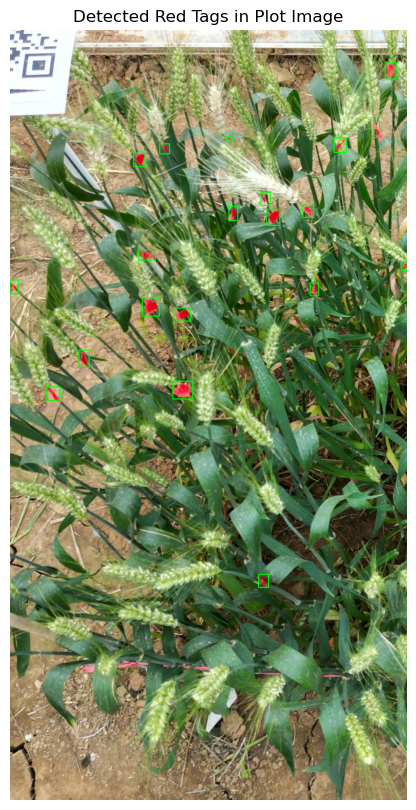

Red Tag Bounding Boxes: [[1111, 95, 1143, 145], [1077, 270, 1094, 318], [640, 316, 657, 330], [960, 320, 996, 363], [443, 337, 472, 367], [366, 365, 399, 405], [743, 481, 771, 520], [867, 519, 899, 555], [648, 523, 674, 565], [760, 531, 799, 579], [380, 651, 430, 682], [1160, 687, 1176, 713], [0, 741, 24, 782], [889, 750, 913, 788], [392, 794, 442, 848], [485, 824, 535, 863], [204, 949, 234, 1000], [482, 1041, 541, 1094], [107, 1058, 148, 1098], [736, 1614, 765, 1653]]


In [2]:
def red_tags_extracted(image_path):
   # 1. Load image and convert color space
    # cv2.imread loads as BGR by default; convert to HSV for robust color segmentation.
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 2. Threshold HSV to isolate red hues
    # In agronomic imaging, red tags or markers often identify individual plants or plots.
    # Define lower/upper HSV bounds for red; note that red straddles the 0°/180° boundary in HSV.
    lower_red = np.array([0, 145, 100])
    upper_red = np.array([10, 255, 255])
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # 3. Apply mask to extract red regions for visualization
    # Bitwise AND retains only pixels within the red HSV range.
    red_extracted = cv2.bitwise_and(image, image, mask=mask)

    # 4. Morphological cleanup of the binary mask
    # 4a. Label connected components in the raw mask
    labels = measure.label(mask)

    # 4b. Remove small spurious detections (e.g., noise, leaf blemishes)
    #    min_size set to 1% of image width in pixels
    min_size = 0.01 * image.shape[1]
    cleaned_mask = morphology.remove_small_objects(labels, min_size=min_size)

    # 4c. Convert to boolean mask and dilate to merge close regions
    cleaned_mask = cleaned_mask > 0
    selem = np.ones((10, 10), dtype=np.uint8)  # structuring element for dilation
    dilated_mask = binary_dilation(cleaned_mask, selem)

    # 5. Extract bounding boxes from cleaned mask
    final_labels = measure.label(dilated_mask)
    bbox_set = []
    for region in measure.regionprops(final_labels):
        # region.bbox returns (min_row, min_col, max_row, max_col)
        minr, minc, maxr, maxc = region.bbox
        # Convert to (x1, y1, x2, y2) for consistency with OpenCV drawing
        bbox_set.append([minc, minr, maxc, maxr])

    # 6. Filter out boxes that are too close to one another
    # Prevent duplicate detections of the same tag by enforcing a minimum distance
    threshold_distance = 0.02 * image.shape[1]  # 2% of image width
    bbox_red_sets = []
    for i, bbox1 in enumerate(bbox_set):
        keep = True
        for bbox2 in bbox_set[i+1:]:
            # Euclidean distance between top-left corners
            dist = np.linalg.norm(np.array(bbox1[:2]) - np.array(bbox2[:2]))
            if dist < threshold_distance:
                keep = False
                break
        if keep:
            bbox_red_sets.append(bbox1)

    # 7. Draw bounding boxes on a copy of the original image
    image_display = image.copy()
    for x1, y1, x2, y2 in bbox_red_sets:
        # Green boxes highlight detected red tags for quick visual QC
        cv2.rectangle(image_display, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return bbox_red_sets, image_display

# Example usage
if __name__ == "__main__":
    image_path = "Data/2.jpg"
    bboxes, image_display = red_tags_extracted(image_path)

    # Convert BGR to RGB for Matplotlib display
    image_display = cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_display)
    plt.axis("off")
    plt.title("Detected Red Tags in Plot Image")
    plt.show()

    print("Red Tag Bounding Boxes:", bboxes)